In this notebook we will be building XGB model and check if the reccomendation engine can be improved by using other algorithms

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab import drive
drive.mount("/content/Drive")

Mounted at /content/Drive


In [3]:
!pip install xgboost

# Creating alternative model

In this step dataset preprocessed in previous step is loaded and simple baseline model is tested.

Each line in a dataset contains data about one user and his final action on the offer.
Either offer has been ignored, viewed or completed (offer proved to be interesting to a customer).

In [4]:
# df = pd.read_csv('./userdata.csv')
df = pd.read_csv('/content/Drive/MyDrive/ADSFinal/data/userdata.csv')

In [5]:
df.head()

,age,became_member_on,gender,id,income,memberdays,event,time,offer_id,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
0,118,20170212,0,68be06ca386d4c31939f3a4f0e3dd783,0,1162,1.0,216.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
1,68,20180426,2,e2127556f4f64592b11af22de27a7932,4,724,1.0,18.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
2,118,20170925,0,8ec6ce2a7e7949b1bf142def7d0e0586,0,937,1.0,462.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
3,118,20171002,0,68617ca6246f4fbc85e91a2a49552598,0,930,1.0,432.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
4,65,20180209,2,389bc3fa690240e798340f5a15918d5c,3,800,2.0,498.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0


In [6]:
print("Dataset contains %s actions" % len(df))

Dataset contains 72628 actions


### Let's plot the actions for one user

From the output can be seen that user completed an offer `0b1e...` and viewed `ae26...`. Offer `2906..` had been ignored twice.

In [7]:

df[df.id == 'e12aeaf2d47d42479ea1c4ac3d8286c6' ]

,age,became_member_on,gender,id,income,memberdays,event,time,offer_id,difficulty,duration,reward,web,email,mobile,social,bogo,discount,informational
5,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,0.0,168.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
6,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,0.0,576.0,2906b810c7d4411798c6938adc9daaa5,10,7,2,1,1,1,0,0,1,0
7146,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,2.0,456.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,1,0,0,0,1,0
50876,26,20140213,2,e12aeaf2d47d42479ea1c4ac3d8286c6,2,2257,1.0,414.0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,0,1,1,1,1,0,0


### Preparing data for training
Let's create user-offer matrix by encoding each id into categorical value.

Recommendation matrix is very similar to embeddings. So we will leverage this and will train embedding along the model.

### Create additional user and offer details tensors

In [8]:
offer_specs = ['difficulty', 'duration', 'reward', 'web',
       'mobile', 'social', 'bogo', 'discount', 'informational']
user_specs = ['age', 'became_member_on', 'gender', 'income', 'memberdays']

In [9]:
N_train = int(0.8 * len(df['event']))
N_test = 1000

train_df = df[:N_train]
test_df = df[N_train:]
print(len(train_df))
print(len(test_df))

58102
14526


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

def random_forest(train_data, train_true, test_data, test_true):

    #hyper-paramater tuning
    values = [25, 50, 100, 200]
    clf = RandomForestClassifier(n_jobs = -1)
    hyper_parameter = {"n_estimators": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    print("Best RF parameter is: ", estimators)
    #applying random forest with best hyper-parameter
    clf = RandomForestClassifier(n_estimators = estimators, n_jobs = -1)
    clf.fit(train_data, train_true)
    #train_pred = clf.predict(train_data)

    return clf

def xgboost_model(train_data, train_true, test_data, test_true):
    #hyper-parameter tuning
    hyper_parameter = {"max_depth":[6, 8, 10, 16], "n_estimators":[60, 80, 100, 120]}
    clf = xgb.XGBClassifier()
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    depth = best_parameter.best_params_["max_depth"]
    print("Best XGB parameter is %s estimators and depth %s: " % (estimators, depth))

    clf = xgb.XGBClassifier(max_depth = depth, n_estimators = estimators)
    clf.fit(train_data, train_true)
    #train_pred = clf.predict(train_data)

    return clf



In [12]:
pred_rf = random_forest(train_df[user_specs + offer_specs],
                       train_df['event'].values.ravel(),
                       test_df[user_specs + offer_specs],
                       test_df['event'].values.ravel())

pred_xgb = xgboost_model(train_df[user_specs + offer_specs],
                       train_df['event'].values.ravel(),
                       test_df[user_specs + offer_specs],
                        test_df['event'].values.ravel())

# error_table_regressions = pd.DataFrame(columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"])
# error_table_regressions = error_table_regressions.append(pd.DataFrame([["XGBoost Regressor", trainMAPE_xgb*100, trainMSE_xgb, testMAPE_xgb*100, testMSE_xgb]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
# error_table_regressions = error_table_regressions.append(pd.DataFrame([["Random Forest Regression", trainMAPE_rf*100, trainMSE_rf, testMAPE_rf*100, testMSE_rf]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))

# error_table_regressions.reset_index(drop = True, inplace = True)

Best RF parameter is:  100
Best XGB parameter is 120 estimators and depth 16: 


In [13]:
def random_forest(train_data, train_true, test_data, test_true):

    clf = RandomForestClassifier(n_estimators = 60, n_jobs = -1)
    clf.fit(train_data, train_true)
    #train_pred = clf.predict(train_data)

    return clf

def xgboost_model(train_data, train_true, test_data, test_true):
    #hyper-parameter tuning

    clf = xgb.XGBClassifier(max_depth = 16, n_estimators = 6)
    clf.fit(train_data, train_true)
    #train_pred = clf.predict(train_data)
    return clf



pred_rf = random_forest(train_df[user_specs + offer_specs],
                       train_df['event'].values.ravel(),
                       test_df[user_specs + offer_specs],
                       test_df['event'].values.ravel())



pred_xgb = xgboost_model(train_df[user_specs + offer_specs],
                       train_df['event'].values.ravel(),
                       test_df[user_specs + offer_specs],
                        test_df['event'].values.ravel())

# error_table_regressions = pd.DataFrame(columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"])
# error_table_regressions = error_table_regressions.append(pd.DataFrame([["XGBoost Regressor", trainMAPE_xgb*100, trainMSE_xgb, testMAPE_xgb*100, testMSE_xgb]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
# error_table_regressions = error_table_regressions.append(pd.DataFrame([["Random Forest Regression", trainMAPE_rf*100, trainMSE_rf, testMAPE_rf*100, testMSE_rf]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))

# error_table_regressions.reset_index(drop = True, inplace = True)

In [14]:
from sklearn.metrics import confusion_matrix,  accuracy_score
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save=False,
                          figname='cm.png'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save:
        plt.savefig(figname, dpi=fig.dpi)
    plt.show()

Confusion matrix, without normalization
[[  0  19]
 [ 10 971]]


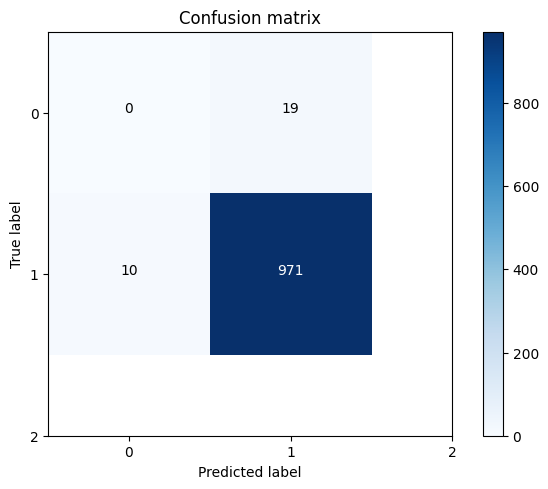

In [60]:
pred1 = pred_rf.predict(test_df[0:1000][user_specs + offer_specs])
test_y = test_df[0:1000]['event'].values.ravel()
#print(pred1)
#print(test_y)
cm = confusion_matrix(test_y, pred1)
classes = [0,1,2]
plot_confusion_matrix(cm, classes, save=True, figname='/content/Drive/MyDrive/ADSFinal/images/Recommen.png')


Confusion matrix, without normalization
[[  0  19]
 [  1 980]]


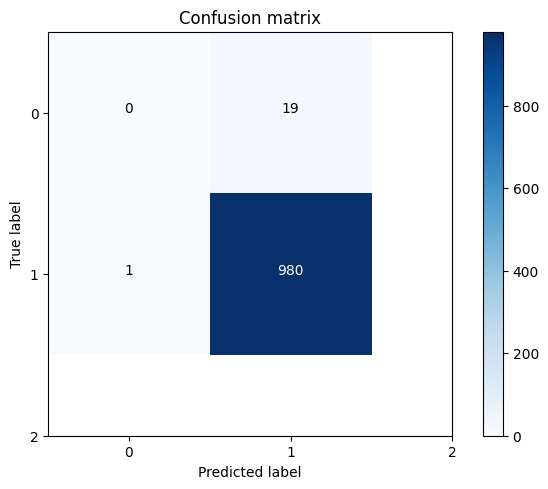

In [64]:
pred2 = pred_xgb.predict(test_df[0:1000][user_specs + offer_specs])
test_y = test_df[0:1000]['event'].values.ravel()
#print(pred2)
#print(test_y)
cm = confusion_matrix(test_y, pred2)
classes = [0,1,2]
plot_confusion_matrix(cm, classes, save=True, figname='/content/Drive/MyDrive/ADSFinal/imagesnXGB-cm.png')

In [24]:
print("Accuracy for RF model: " + str(100*accuracy_score(test_y, pred1))+ "%" )
print("Accuracy for XGB model: " + str(100*accuracy_score(test_y, pred2))+ "%" )

Accuracy for RF model: 67.5%
Accuracy for XGB model: 70.39999999999999%


In [25]:
from sklearn.metrics import f1_score, recall_score, precision_score

print("F1 score for RF model: " + str(f1_score(test_y, pred1, average='weighted')))
print("Recall score for RF model: " + str(recall_score(test_y, pred1, average='weighted')))
print("Precision score for RF model: " + str(precision_score(test_y, pred1, average='weighted')))

print("")
print("F1 score for XGB model: " + str(f1_score(test_y, pred2, average='weighted')) )
print("Recall score for XGB model: " + str(recall_score(test_y, pred2, average='weighted')) )
print("Precision score for XGB model: " + str(precision_score(test_y, pred2, average='weighted')) )

F1 score for RF model: 0.681069120138174
Recall score for RF model: 0.675
Precision score for RF model: 0.6894032281195209

F1 score for XGB model: 0.6967267055432156
Recall score for XGB model: 0.704
Precision score for XGB model: 0.6921574074074074


Results seem to be promising.
Let's try to improve them even more, and simplify data as from the correlation matrix it can be noticed that model has difficulties to differentiate if user will view an offer or even respond to it.
This can be due to the fact that responding to an offer implies that user had definitely viewed an offer.

# Approach 2. Remove outlier fields

In [32]:
df = pd.read_csv('/content/Drive/MyDrive/ADSFinal/data/userdata.csv')
from pandas.api.types import CategoricalDtype

In [36]:
df['member_days'] = df['became_member_on'].astype(str).astype('datetime64[ns]')
df['member_days'] = df['member_days'] - df['member_days'].min()
df['member_days'] = df['member_days'].apply(lambda x: int(x.days))

Let's check once again the correlation between gender and event response.
We are interested in X and O genders. Where X is the customers with anonymized data.

<Axes: ylabel='Frequency'>

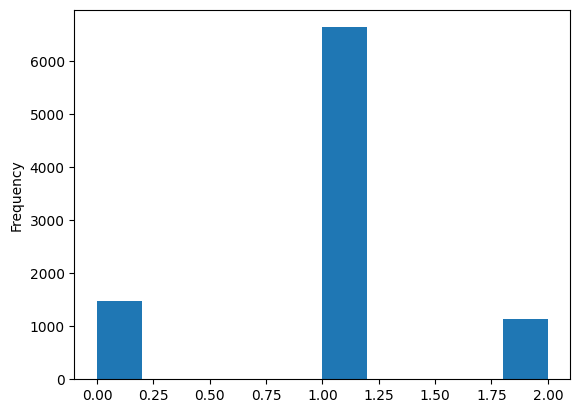

In [37]:
df[df.gender == 0]['event'].plot.hist()#.count_values()

<Axes: ylabel='Frequency'>

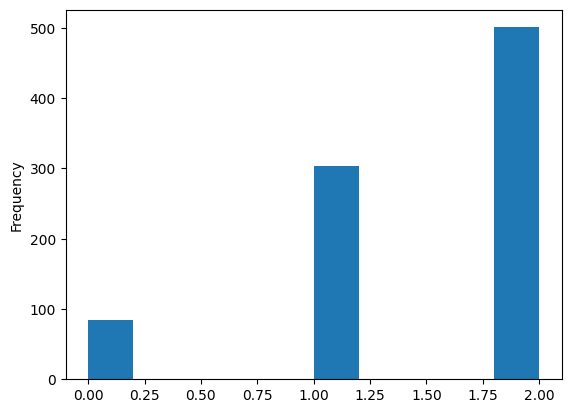

In [38]:
df[df.gender == 1]['event'].plot.hist()#.count_values()

<Axes: ylabel='Frequency'>

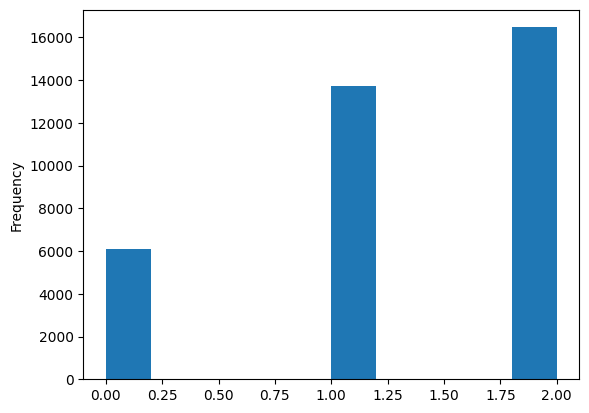

In [39]:
df[df.gender == 2]['event'].plot.hist()#.count_values()

<Axes: ylabel='Frequency'>

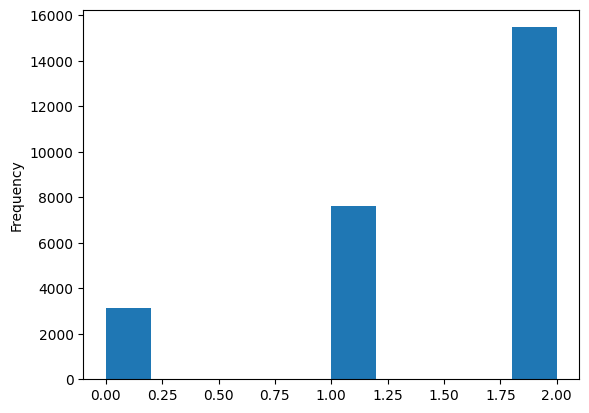

In [40]:
df[df.gender == 3]['event'].plot.hist()#.count_values()

<Axes: ylabel='Frequency'>

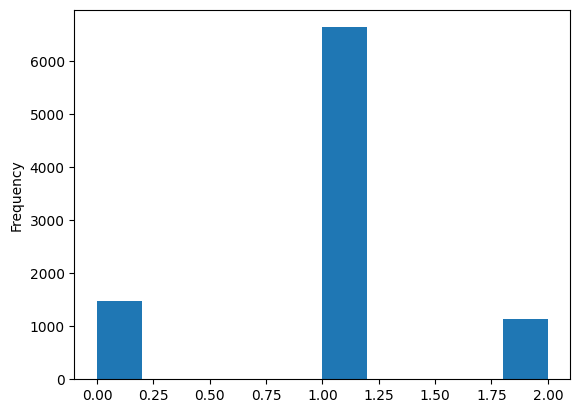

In [41]:
df[df.income == 0]['event'].plot.hist()#.count_values()

Now we test the model performance with removing rows where user with age and income as None
They seem to view offer but rarely respond to it.

In [42]:
# We remove them by index as it seems to be the easiest way
indexes_to_drop = list(df[df.gender == 0].index) + list(df[df.income == 0].index)
df = df.drop(df.index[indexes_to_drop]).reset_index()

In [43]:
df = df.reset_index()

In [45]:
df['became_member_date'] = df['became_member_on'].astype(str).astype('datetime64[ns]')
df[df['member_days'] == 10]

,level_0,index,age,became_member_on,gender,id,income,memberdays,event,time,...,reward,web,email,mobile,social,bogo,discount,informational,member_days,became_member_date
1544,1544,1767,18,20130808,2,2825186736d4433c98653bcea5957cb3,3,2446,1.0,426.0,...,2,1,1,1,0,0,1,0,10,2013-08-08
6187,6187,7099,38,20130808,2,2ce987015ec0404a97ba333e8e814090,4,2446,2.0,462.0,...,2,1,1,1,0,0,1,0,10,2013-08-08
25138,25138,28716,90,20130808,2,8f11863ca0bb42f78bacaff28e0a30ff,4,2446,1.0,612.0,...,3,1,1,1,1,0,1,0,10,2013-08-08
27477,27477,31397,38,20130808,2,2ce987015ec0404a97ba333e8e814090,4,2446,0.0,576.0,...,5,1,1,1,0,1,0,0,10,2013-08-08
32220,32220,36845,18,20130808,2,2825186736d4433c98653bcea5957cb3,3,2446,1.0,6.0,...,0,1,1,1,0,0,0,1,10,2013-08-08
38523,38523,44072,18,20130808,2,2825186736d4433c98653bcea5957cb3,3,2446,1.0,336.0,...,0,0,1,1,1,0,0,1,10,2013-08-08
38524,38524,44073,18,20130808,2,2825186736d4433c98653bcea5957cb3,3,2446,1.0,576.0,...,0,0,1,1,1,0,0,1,10,2013-08-08
46523,46523,53234,38,20130808,2,2ce987015ec0404a97ba333e8e814090,4,2446,1.0,504.0,...,10,0,1,1,1,1,0,0,10,2013-08-08
55944,55944,64037,90,20130808,2,8f11863ca0bb42f78bacaff28e0a30ff,4,2446,2.0,492.0,...,5,1,1,1,1,1,0,0,10,2013-08-08
62209,62209,71264,90,20130808,2,8f11863ca0bb42f78bacaff28e0a30ff,4,2446,1.0,342.0,...,10,1,1,1,1,1,0,0,10,2013-08-08


Let's encode `event` field to be only binary value, with event ignored as 0, and offer completed - as 1.

In [46]:
df['event'] = df['event'].map({0:0, 1:0, 2:1})

In [47]:
offer_specs = ['difficulty', 'duration', 'reward', 'web', 'email',
       'mobile', 'social', 'bogo', 'discount', 'informational']
user_specs = ['age', 'member_days', 'gender', 'income']

In [48]:
N_train = int(0.8 * len(df['event']))
N_test = 1000

train_df = df[:N_train]
test_df = df[N_train:]
print(len(train_df))
print(len(test_df))

50694
12674


In [49]:
pred_rf = random_forest(train_df[user_specs + offer_specs],
                       train_df['event'].values.ravel(),
                       test_df[user_specs + offer_specs],
                       test_df['event'].values.ravel())

pred_xgb = xgboost_model(train_df[user_specs + offer_specs],
                       train_df['event'].values.ravel(),
                       test_df[user_specs + offer_specs],
                        test_df['event'].values.ravel())

[1 1 1 ... 1 0 0]
[1 1 1 ... 1 0 0]
Accuracy for RF model: 71.9346694019252%
Confusion matrix, without normalization
[[3450 1706]
 [1851 5667]]


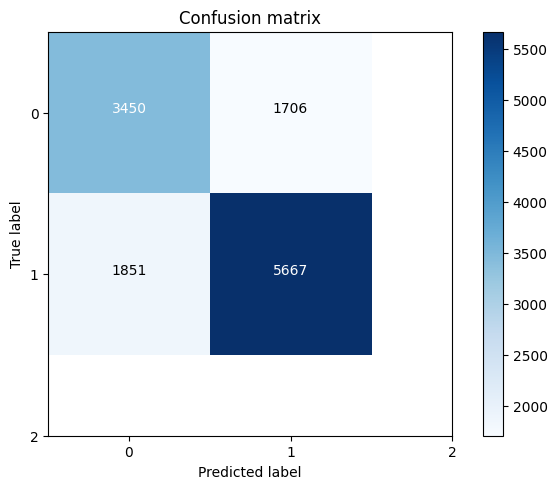

In [50]:
pred1 = pred_rf.predict(test_df[user_specs + offer_specs])
test_y = test_df['event'].values.ravel()
print(pred1)
print(test_y)

print("Accuracy for RF model: " + str(100*accuracy_score(test_y, pred1))+ "%" )
cm = confusion_matrix(test_y, pred1)
classes = [0,1,2]
plot_confusion_matrix(cm, classes)

[1 1 1 ... 1 0 0]
[1 1 1 ... 1 0 0]
Accuracy for XGB model: 71.95833990847404%
Confusion matrix, without normalization
[[2980 2176]
 [1378 6140]]


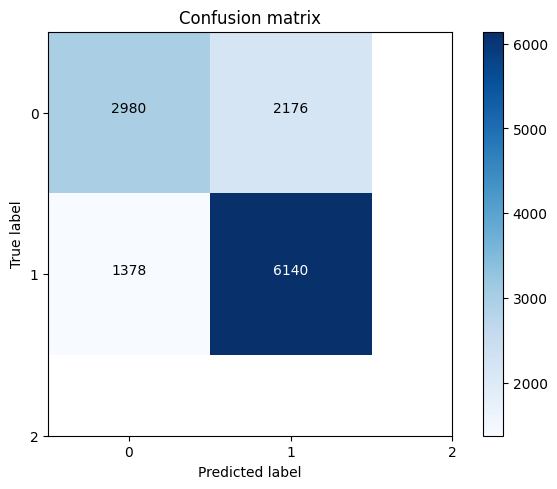

In [51]:
pred2 = pred_xgb.predict(test_df[user_specs + offer_specs])
test_y = test_df['event'].values.ravel()
print(pred2)
print(test_y)

print("Accuracy for XGB model: " + str(100*accuracy_score(test_y, pred2))+ "%" )
cm = confusion_matrix(test_y, pred2)
classes = [0,1,2]
plot_confusion_matrix(cm, classes)

It seem that results are the same.
Let's try the model with encoding now
an `event` field to be only binary value, with event ignored as 0, and offer completed - as 1.

# Approach 3. Building Performance optimized model

In [54]:
df = pd.read_csv('/content/Drive/MyDrive/ADSFinal/data/userdata.csv')

df['member_days'] = df['became_member_on'].astype(str).astype('datetime64[ns]')
df['member_days'] = df['member_days'] - df['member_days'].min()
df['member_days'] = df['member_days'].apply(lambda x: int(x.days))

df['event'] = df['event'].map({0:0, 1:1, 2:1})

df = df.reset_index()

offer_specs = ['difficulty', 'duration', 'reward', 'web', 'email',
       'mobile', 'social', 'bogo', 'discount', 'informational']
user_specs = ['age', 'member_days', 'gender', 'income']

N_train = int(0.8 * len(df['event']))
N_test = 1000

train_df = df[:N_train]
test_df = df[N_train:]
print(len(train_df))
print(len(test_df))

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

def random_forest(train_data, train_true, test_data, test_true):

    clf = RandomForestClassifier(n_estimators = 100, n_jobs = -1)
    clf.fit(train_data, train_true)
    #train_pred = clf.predict(train_data)

    return clf

def xgboost_model(train_data, train_true, test_data, test_true):

    clf = xgb.XGBClassifier(max_depth = 16, n_estimators = 60)
    clf.fit(train_data, train_true)
    #train_pred = clf.predict(train_data)

    return clf

58102
14526


In [55]:
pred_rf = random_forest(train_df[user_specs + offer_specs],
                       train_df['event'].values.ravel(),
                       test_df[user_specs + offer_specs],
                       test_df['event'].values.ravel())

pred_xgb = xgboost_model(train_df[user_specs + offer_specs],
                       train_df['event'].values.ravel(),
                       test_df[user_specs + offer_specs],
                        test_df['event'].values.ravel())

Accuracy for RF model: 97.1%
Confusion matrix, without normalization
[[  0  19]
 [ 10 971]]


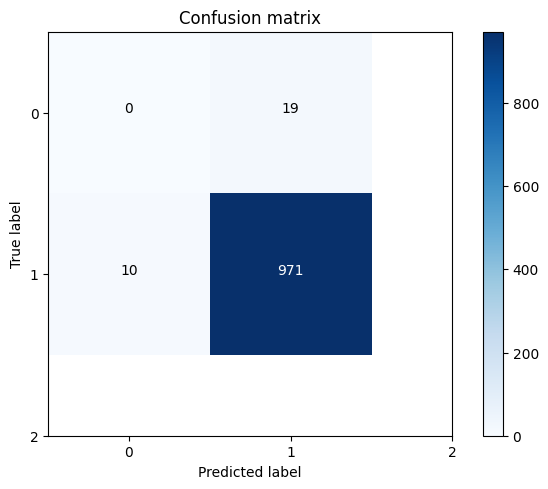

In [62]:
pred1 = pred_rf.predict(test_df[0:1000][user_specs + offer_specs])
test_y = test_df[0:1000]['event'].values.ravel()
#print(pred1)
#print(test_y)

print("Accuracy for RF model: " + str(100*accuracy_score(test_y, pred1))+ "%" )
cm = confusion_matrix(test_y, pred1)
classes = [0,1,2]
plot_confusion_matrix(cm, classes, save=True, figname='/content/Drive/MyDrive/ADSFinal/images/RF-cm.png')

Accuracy for XGB model: 98.0%
Confusion matrix, without normalization
[[  0  19]
 [  1 980]]


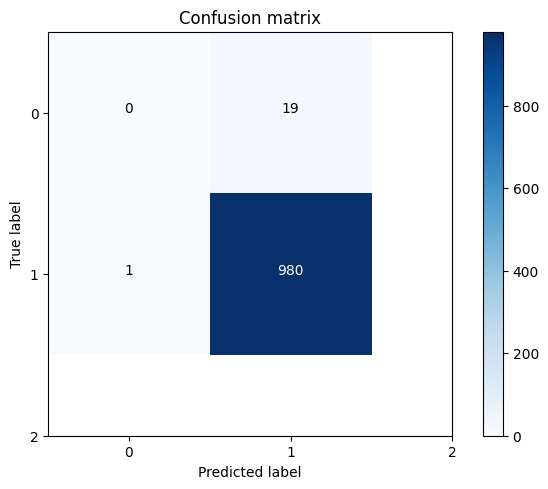

In [63]:
pred2 = pred_xgb.predict(test_df[0:1000][user_specs + offer_specs])
test_y = test_df[0:1000]['event'].values.ravel()
#print(pred2)
#print(test_y)

print("Accuracy for XGB model: " + str(100*accuracy_score(test_y, pred2))+ "%" )
cm = confusion_matrix(test_y, pred2)
classes = [0,1,2]
plot_confusion_matrix(cm, classes, save=True, figname='/content/Drive/MyDrive/ADSFinal/images/XGB.png')

This looks like a significant improve that can be used in production to save costs and send offers to those users who are going to be interested in companies offers without ignoring them.

In [59]:
from sklearn.metrics import f1_score, recall_score, precision_score

print("F1 score for RF model: " + str(f1_score(test_y, pred1, average='weighted')))
print("Recall score for RF model: " + str(recall_score(test_y, pred1, average='weighted')))
print("Precision score for RF model: " + str(precision_score(test_y, pred1, average='weighted')))

print("")
print("F1 score for XGB model: " + str(f1_score(test_y, pred2, average='weighted')) )
print("Recall score for XGB model: " + str(recall_score(test_y, pred2, average='weighted')) )
print("Precision score for XGB model: " + str(precision_score(test_y, pred2, average='weighted')) )

F1 score for RF model: 0.966566210045662
Recall score for RF model: 0.971
Precision score for RF model: 0.9621727272727272

F1 score for XGB model: 0.971090909090909
Recall score for XGB model: 0.98
Precision score for XGB model: 0.9623423423423424


This proves to be a very good model for ad hoc predictions and predictions on subsections of customer by regions or cities.